# 向量化回测系统的设计

<div class="alert alert-block alert-success">
Keywords:  Quantitative Investment; Vector Backtesting Framework
    
Draft: 2023.5.1 Updated:2024.7.25 Version: 0.0.3
</div>


```{contents}
```

本节提供了一个实用的向量化回测(Vectorised Backtester)框架，它提供了回测的基本思路，该框架被业界已被普遍证明是有效和可实施的。

![backtester.png](images/backtester.png)

回测系统的应该包含两个主要部分：
1. 要交易的市场和标的物，回测的时间范围，交易频率，交易成本，交易方法，以及对于策略的评估等等。
2. 策略，即策略师关于如何交易的代码。

当具体得设计一个回测系统时，可以分成以下几个部分。

## 1. 资产池

投资股票池为可以投资的标的证券范围，即我们准备使用哪些股票来进行投资。例如，A50指数作为国内我们在[上交所网站](http://www.sse.com.cn/home/index.shtml)上，检索A50指数成分股。
> 上海证券市场规模大、流动性好的最具代表性的50只股票组成样本股，以便综合反映上海证券市场最具市场影响力的一批龙头企业的整体状况。上证50指数自2004年1月2日起正式发布。其目标是建立一个成交活跃、规模较大、主要作为衍生金融工具基础的投资指数。——上交所

In [1]:
ticker = {'浦发银行':'600000', '上海机场':'600009', '民生银行':'600016',
            '中国石化':'600028', '中信证券':'600030', '三一重工':'600031',
            '招商银行':'600036', '保利地产':'600048', '中国联通':'600050',
            '上汽集团':'600104', '复星医药':'600196', '恒瑞医药':'600276',
            '万华化学':'600309', '通威股份':'600438', '贵州茅台':'600519',
            '山东黄金':'600547', '恒生电子':'600570', '海螺水泥':'600585',
            '用友网络':'600588', '海尔智家':'600690', '三安光电':'600703',
            '闻泰科技':'600745', '山西汾酒':'600809', '海通证券':'600837',
            '伊利股份':'600887', '航发动力':'600893', '中泰证券':'600918',
            '隆基股份':'601012', '中信建投':'601066', '中国神华':'601088',
            '工业富联':'601138', '兴业银行':'601166', '国泰君安':'601211',
            '农业银行':'601288', '中国平安':'601318', '新华保险':'601336',
            '工商银行':'601398', '中国太保':'601601', '中国人寿':'601628',
            '中国建筑':'601668', '华泰证券':'601688', '光大银行':'601818',
            '中国石油':'601857', '中国中免':'601888', '紫金矿业':'601899',
            '中金公司':'601995', '药明康德':'603259', '海天味业':'603288',
            '韦尔股份':'603501', '兆易创新':'603986'}

定义完股票池后，我们可以开始收集、整理和截取数据：

In [ ]:
import tushare
import warnings
warnings.filterwarnings('ignore')
for i in ticker:
    df = tushare.get_k_data(ticker[i], start='2000-01-01', end='2020-02-01')  #获取某个时间段内的深圳指数
    df.to_csv('datasets/A50/%s.csv' %i)

从tushare API读取的同时，我们将数据存储在'datasets/A50/'路径下。

原始的股票数据是按照每个股票，这里我们称其为tickers，来单独存放的。为了进行向量式计算，我们将其重新组合成"OpenPrice", "HighestPrice", "LowestPrice", "ClosePrice", "Volume"这5个2维向量。

![data_process](images/data_process.png)

In [4]:
import pandas as pd
ClosePrice = pd.DataFrame()
OpenPrice = pd.DataFrame()
HighestPrice = pd.DataFrame()
LowestPrice = pd.DataFrame()
Volume = pd.DataFrame()

for i in ticker:
    df = pd.read_csv('datasets/A50/%s.csv' %i, index_col=0)
    df.index = df['date']
    ClosePrice[i] = df['close']
    OpenPrice[i] = df['open']
    HighestPrice[i] = df['high']
    LowestPrice[i] = df['low']
    Volume[i] = df['volume']
dates = ClosePrice.index.values

In [5]:
ClosePrice.tail()

,浦发银行,上海机场,民生银行,中国石化,中信证券,三一重工,招商银行,保利地产,中国联通,上汽集团,...,华泰证券,光大银行,中国石油,中国中免,紫金矿业,中金公司,药明康德,海天味业,韦尔股份,兆易创新
date,,,,,,,,,,,,,,,,,,,,,
2020-01-17,10.42,72.47,5.28,3.855,22.644,15.261,32.217,13.54,5.65,22.247,...,18.692,3.555,5.17,86.63,4.20,NaN,56.676,51.067,129.330,127.433
2020-01-20,10.44,71.16,5.31,3.835,22.993,15.631,32.597,13.40,5.74,21.657,...,18.882,3.575,5.18,83.68,4.12,NaN,57.319,52.131,138.959,139.162
2020-01-21,10.27,69.61,5.24,3.795,22.478,14.901,32.077,12.87,5.60,20.607,...,18.322,3.505,5.12,80.53,3.94,NaN,57.402,52.082,135.626,136.826
2020-01-22,9.96,70.17,5.25,3.765,22.504,15.281,32.107,13.29,5.56,20.717,...,18.412,3.545,5.07,81.36,4.01,NaN,57.759,51.009,137.085,146.101
2020-01-23,9.54,68.19,5.07,3.725,21.370,14.411,31.097,12.75,5.33,20.117,...,17.792,3.395,4.97,78.78,3.87,NaN,55.997,49.780,136.774,142.734


## 2. 策略/信号

我们知道在技术分析里，均线交叉策略是一类应用广泛的策略，它的策略想法如下：
- 5日的均线称为MA_5
- 10日的均线称为MA_10
- MA_5上穿MA_10则买入，买入数量为上穿后的幅度
- MA_5下穿MA_10则卖出，卖出数量为下穿后的幅度

In [6]:
def ma(price, window):
    # window 为滑动窗口，即均线计算的窗口长度
    return price.rolling(window).mean()

five_ma = ma(ClosePrice, 5)   
ten_ma = ma(ClosePrice, 10)
signal= (five_ma-ten_ma)/ten_ma  

## 3.交易规则

在交易中，使用什么价格进行撮合交易是我们关心的问题，是开盘价、收盘价、还是别的？这里以开盘价为例：

<img src="images/trade_rules.png" alt="images/trade_rules.png" width="600">

In [7]:
import numpy as np
def deal(signal, dates, start_date, end_date, open_price, maxlookback=50):
    """
                    -----------------------------------------------------------------------------
    time                |...|      idx-1      |      idx       |      idx+1       |
                    -----------------------------------------------------------------------------
                        |   |                 |     dates      |                  |
                    -----------------------------------------------------------------------------
    signal               |...|     signal     |                |       ...        |
                    -----------------------------------------------------------------------------
    Openprice trade     |...|                 |   OpenPrice    |     post_open    |
                    -----------------------------------------------------------------------------
    """
    # 选择起始日期 - 终止日期
    start_idx = np.where(dates>=start_date)[0][0]
    end_idx = np.where(dates>end_date)[0][0]
    idx = np.arange(start_idx+maxlookback, end_idx)
    
    # 重新采样dates、signal
    resample_dates = dates[idx]
    resample_signal = signal.iloc[idx-1,:]                                

    # 对信号进行归一化，变成权重
    scaled_resample_wgts = (resample_signal.T / (np.nansum(np.abs(resample_signal), axis=1) + 1e-20)).T

    
    # 计算交易价格和收益率
    open_price = pd.DataFrame(open_price).fillna(method='ffill').values   
    open_price = open_price[idx]
    post_open = np.nan * np.zeros_like(open_price)
    post_open[:-1] = open_price[1:]
    resample_return = post_open/open_price - 1
    resample_tradeprice = open_price
    
    return resample_return, resample_tradeprice, scaled_resample_wgts, resample_dates


In [8]:
resample_return, resample_tradeprice, scaled_resample_wgts, resample_dates = deal(signal,
                                                                                 dates=dates, 
                                                                                 start_date='2010-01-01',
                                                                                 end_date = '2020-01-01',
                                                                                 open_price=OpenPrice,
                                                                                 maxlookback=50)

## 4.评估

### 4.1 收益率PNL

计算盈亏PNL(Profit&Loss)情况：

In [9]:
pnl = resample_return * scaled_resample_wgts      # 盈亏=收益率 * 归一化后的信号权重   
pnl = pnl.sum(axis=1)
cpnl = np.cumsum(pnl)

考虑手续费为万1时的盈亏(PNL)情况:

In [10]:
pre_scaled_resample_wgts = scaled_resample_wgts.shift(1)     #计算昨日权重
chg = scaled_resample_wgts - pre_scaled_resample_wgts        #计算权重变化
turnover = np.nansum(np.nan_to_num(np.abs(chg)), axis=1)        #换手率 = |权重变化|，nan值变为0，再求和
avg_turnover = np.nanmean(turnover)

In [11]:
cost = 0.001           
net_pnl = pnl - cost * turnover     #盈亏-手续费*换手率
net_cpnl = np.cumsum(net_pnl)

### 4.2 夏普比率

In [12]:
sharpe =  np.sqrt(252) * np.nanmean(net_pnl) / np.nanstd(net_pnl) 

### 4.3 损失回撤

In [13]:
def drawdown(cpnl):
    _cpnl = cpnl.values * np.ones((len(cpnl), len(cpnl)))
    _cpnl = np.tril(_cpnl)
    max_cpnl = np.nanmax(_cpnl, axis=1)
    return pd.Series(cpnl - max_cpnl, index=cpnl.index)


drawdown = drawdown(cpnl)
max_drawdown = round(np.abs(np.min(drawdown)), 4)

### 4.4 可视化信号表现

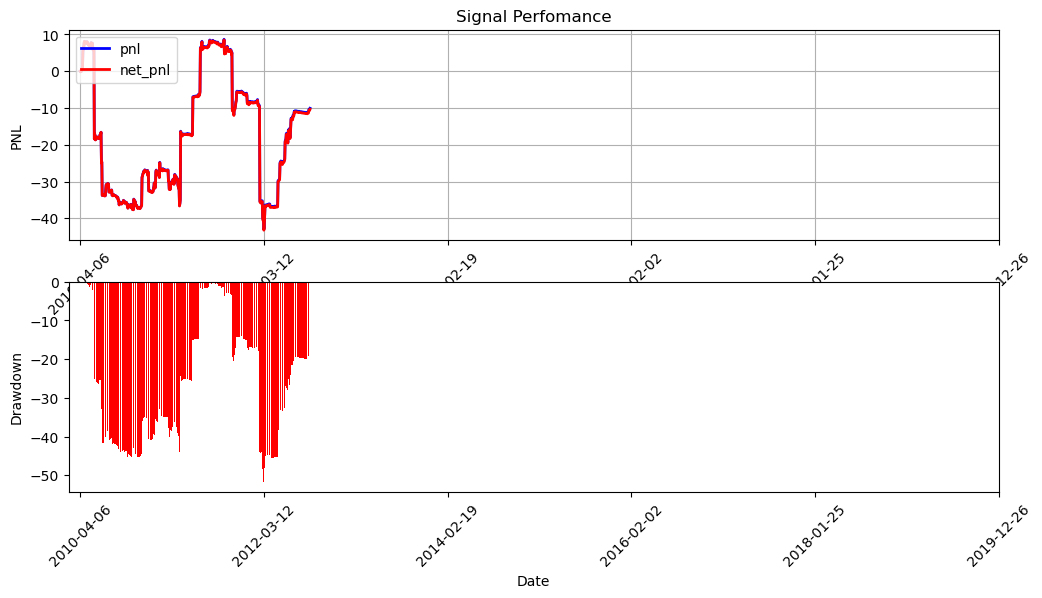

In [19]:
import matplotlib.pyplot as plt
figure, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

# 绘制收益率PNL曲线
pnl = np.zeros(len(cpnl)+1)
pnl[1:] = cpnl
pnl_line = ax[0].plot(pnl, color='b', linewidth=2, label='pnl')

net_pnl = np.zeros(len(net_cpnl)+1)
net_pnl[1:] = net_cpnl
net_pnl_line = ax[0].plot(net_pnl, color='r', linewidth=2, label='net_pnl')

dates = resample_dates
step = len(dates)/20
space = [i for i in np.arange(len(dates)) if i%step==0]
dates_str = [i.split(' ')[0] for i in dates[space]]
if len(np.unique(dates_str)) <= 3:
    step = int(len(dates)/5)
    space = [i for i in np.arange(len(dates)) if i%step==0]
    dates_str = [i for i in dates[space]]

ax[0].set_ylabel('PNL')
ax[0].set_xticks(space, dates_str, rotation=45)
ax[0].set_title('Signal Perfomance')
ax[0].legend(loc=2)
ax[0].grid()

# 绘制回撤曲线
ax[1].bar(drawdown.index, height=drawdown, color='red')
ax[1].set_xticks(space, dates_str, rotation=45)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Drawdown')
plt.show()


In [18]:
net_pnl

array([ 0.        , -0.15447166, -0.11542349, ...,         nan,
               nan,         nan])

## 5. 向量式回测系统的优缺点

### 优点

- 快速： 向量化回测系统实现回测的速度非常快，1000多只股票和1000多个时间戳的回测可以在1秒内完成。这种高效的框架有利于策略师在短时间内开发和分析交易理念。

- 矩阵计算友好： 向量化回测系统允许在策略产生和性能统计期间进行矩阵计算。相比之下，事件驱动的回测器在序列中隔离市场数据，给阵列计算带来困难。

- 从信号处理角度看待策略：向量化回测系统使用框架式数据或面板式数据，帮助策略师从信号处理的角度来考虑数据。特别是，一些操作，如随着时间的推移增强或减弱信号，如果使用向量化回测系统就会变得很方便。

### 缺点
1. 当未来的数据被意外地包括在模拟中的某个点上，而该数据实际上是不可用的，那么回测系统就会被引入前瞻性偏差（Look-ahead bias）。而当策略师在代码中操作向量时，超前指数N+k，即超出当前N，将带来前瞻偏差。这导致了一些不容易察觉的问题。
2. 订单类型问题是向量化回测器的另一个缺点。市场订单和限价订单是常见的订单类型。而向量式回测器只模拟TWAP或VWAP的交易，这些都是之前估计的交易价格。


## 参考

1. Michael L. Halls-Moore, Strategies Optimisation, *Successful Algorithm Trading* , Chapter 3
2. 《高效的无效》Efficiently Inefficient, Lasse Heje Pedersen, 2021